In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import glob
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# VEST NJ 2016

## VEST's Documentation File

Election results primarily from individual county canvass reports via OpenElections (https://github.com/openelections/openelections-data-nj/). Results from Burlington, Camden, Middlesex, and Warren counties were partly or wholly replaced using the Statement of the Vote from the respective counties.  

Precinct shapefile from New Jersey Geographic Information Network (https://njogis-newjersey.opendata.arcgis.com/datasets/election-districts-for-new-jersey). Naval Weapons Station Earle in Monmouth County was added as an unassigned district.  

All counties except Middlesex, Sussex, and Warren report mail votes and provisional votes at the municipal and/or ward level. Essex, Gloucester, Hudson, Monmouth, Ocean, and Union further subdivide these vote types by other districts on the same ballot. Camden, Cape May, Essex, Gloucester, Hudson, Monmouth, Morris, Sussex, and Warren report overseas ballots countywide or by congressional district. All votes were distributed by candidate to precincts based on their share of the precinct-level reported vote of the respective reporting unit.  

The following modifications to the shapefile were made to reverse changes in precinct boundaries enacted since 2016:  

Gloucester: Merge Glassboro 1/13  
Hudson: Merge Jersey City Ward E 9/24, 6/25; Realign Union City Ward 9 precincts  
Passaic: Merge Pompton Lakes 3/6  
Union: Merge Elizabeth City W1 6/9, W2 2/11, W3 10/13, W4 7/10; Adjust Elizabeth City W2 4/7, 6/7, W3 3/6, W6 1/5  

G16PREDCLI - Hillary Rodham Clinton (Democratic Party)  
G16PRERTRU - Donald J. Trump (Republican Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
G16PREGSTE - Jill Stein (Green Party)  
G16PRECCAS - Darrell Castle (Constitution Party)  
G16PREOKEN - Alyson Kennedy (Socialist Workers Party)  
G16PREOFUE - Rocky Roque De La Fuente (American Delta Party)  
G16PREOMOO - Monica Moorehead (Workers World Party)  
G16PREOLAR - Gloria La Riva (Socialism and Liberation)  

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nj_2016/nj_2016.shp")

In [3]:
vest_shp.shape

(6339, 20)

In [4]:
vest_shp.head(1)

,CONGR_DIST,LEGIS_DIST,COCOM_DIST,ELECD_KEY,COUNTY,MUN_NAME,MCODE_SVRS,MCODE_1040,WARD_CODE,ELECD_CODE,G16PREDCLI,G16PRERTRU,G16PRELJOH,G16PREGSTE,G16PRECCAS,G16PREOKEN,G16PREOFUE,G16PREOMOO,G16PREOLAR,geometry
0,02,02,05,001-0117-01-00,Atlantic,Mullica Township,0117,0117,01,00,446,348,9,4,5,2,1,0,0,"POLYGON ((427942.516 266334.807, 426253.899 26..."


Import election results by county

In [5]:
#Read in Sorted precinct files for counties listed by VEST
path = "./raw-from-source/CountyData/counties"
  
# csv files in the path
files=os.listdir(path)
 
# defining an empty list to store 
# content
nj_2016_counties = pd.DataFrame()
content = []
  
# checking all the csv files in the 
# specified path
for filename in files:
    
    # reading content of csv file
    # content.append(filename)
    nj_2016_counties = pd.read_csv(path+'/'+filename)
    content.append(nj_2016_counties)
    
# converting content to data frame
df_2016_cnty = pd.concat(content)
print(df_2016_cnty.shape)
df_2016_cnty.head(1)

(156880, 7)


,county,precinct,office,district,candidate,party,votes
0,Union,Berkeley Heights District 1,President,NaN,Hillary Rodham CLINTON Timothy Michael KAINE,Dem,365


In [6]:
election_results = df_2016_cnty

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Jersey"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
nj_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
#Create list of fips codes
fips_file["unique_ID"] =  "34" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()
nj_fips_dict

{'ATLANTIC': '001',
 'BERGEN': '003',
 'BURLINGTON': '005',
 'CAMDEN': '007',
 'CAPE MAY': '009',
 'CUMBERLAND': '011',
 'ESSEX': '013',
 'GLOUCESTER': '015',
 'HUDSON': '017',
 'HUNTERDON': '019',
 'MERCER': '021',
 'MIDDLESEX': '023',
 'MONMOUTH': '025',
 'MORRIS': '027',
 'OCEAN': '029',
 'PASSAIC': '031',
 'SALEM': '033',
 'SOMERSET': '035',
 'SUSSEX': '037',
 'UNION': '039',
 'WARREN': '041'}

In [8]:
candidates_dict = {'Hillary Clinton':'G16PREDCLI', 
                   'Donald Trump':'G16PRERTRU', 
                   'Gloria LaRiva':'G16PREOLAR',
                   'Darrell Castle':'G16PRECCAS',
                   'Monica Moorehead':'G16PREOMOO', 
                   'Alyson Kennedy':'G16PREOKEN',
                   'Gary Johnson':'G16PRELJOH', 
                   'Rocky de la Fuente':'G16PREOFUE', 
                   'Jill Stein':'G16PREGSTE', 
                   'Donald J. Trump':'G16PRERTRU',
                   'Rocky Roque De La Fuente':'G16PREOFUE', 
                   'Monica Moorhead':'G16PREOMOO', 
                   'Trump/Pence':'G16PRERTRU', 
                   'Clinton/Kaine':'G16PREDCLI', 
                   'Stein/Baraka':'G16PREGSTE',
                   'Castle/Bradley':'G16PRECCAS', 
                   'La Riva/Puryear':'G16PREOLAR', 
                   'Moorehead/Lilly':'G16PREOMOO',
                   'Fuentes/Steinberg':'G16PREOFUE', 
                   'Kennedy/hart':'G16PREOKEN', 
                   'Johnson/Weld':'G16PRELJOH',
                   'Darrell L. Castle':'G16PRECCAS', 
                   'Gloria La Riva':'G16PREOLAR',
                   'Hillary Rodham Clinton':'G16PREDCLI', 
                   'DONALD J. TRUMP':'G16PRERTRU', 
                   'HILLARY RODHAM CLINTON':'G16PREDCLI',
                   'MONICA MOOREHEAD':'G16PREOMOO', 
                   'ROCKY ROQUE DE LA FUENTE':'G16PREOFUE', 
                   'DARRELL CASTLE':'G16PRECCAS',
                   'ALYSON KENNEDY':'G16PREOKEN', 
                   'JILL STEIN':'G16PREGSTE', 
                   'GLORIA LA RIVA':'G16PREOLAR', 
                   'GARY JOHNSON':'G16PRELJOH',
                   'Kennedy/Hart':'G16PREOKEN', 
                   'De La Fuente/Steinberg':'G16PREOFUE',
                   'Moorehead/Lily':'G16PREOMOO', 
                   'Rocky Roque de la Fuente':'G16PREOFUE',
                   'Donald J. TRUMP / Michael R. PENCE':'G16PRERTRU',
                   'Hillary Rodham CLINTON / Timothy Michael KAINE':'G16PREDCLI',
                   'Monica MOOREHEAD / Lamont LILLY':'G16PREOMOO', 
                   'Jill STEIN / Ajamu BARAKA':'G16PREGSTE',
                   'Gary JOHNSON / William WELD':'G16PRELJOH', 
                   'Alyson KENNEDY / Osborne HART':'G16PREOKEN',
                   'Gloria LaRIVA / Eugene PURYEAR':'G16PREOLAR',
                   'Rocky Roque DeLaFUENTE / Michael STEINBERG':'G16PREOFUE',
                   'Darrell CASTLE / Scott BRADLEY':'G16PRECCAS', 
                   'Donald J. Trump Michael R. Pence':'G16PRERTRU',
                   'Hillary Rodham Clinton Timothy Michael Kaine':'G16PREDCLI',
                   'Jill Stein Ajamu Baraka':'G16PREGSTE',
                   'Rocky Roque De La Fuente Michael Steinberg':'G16PREOFUE',
                   'Gary Johnson William Weld':'G16PRELJOH', 
                   'Darrell Castle Scott Bradley':'G16PRECCAS',
                   'Monica Moorehead Lamont Lilly':'G16PREOMOO', 
                   'Gloria La Riva Eugene Puryear':'G16PREOLAR',
                   'Alyson Kennedy Osborne Hart':'G16PREOKEN', 
                   'Donald J. TRUMP & Michael R. PENCE':'G16PRERTRU',
                   'Hillary Rodham CLINTON & Timothy Michael KAINE':'G16PREDCLI',
                   'Darrell CASTLE & Scott BRADLEY':'G16PRECCAS',
                   'Gary JOHNSON & William WELD':'G16PRELJOH',
                   'Gloria La RIVA & Eugene PURYEAR':'G16PREOLAR',
                   'Rocky Roque De La FUENTE & Michael STEINBERG':'G16PREOFUE',
                   'Jill STEIN & Ajamu BARAKA':'G16PREGSTE', 
                   'Monica MOOREHEAD & Lamont LILLY':'G16PREOMOO',
                   'Alyson KENNEDY & Osborne HART':'G16PREOKEN', 
                   'CLINTON - Kaine':'G16PREDCLI', 
                   'TRUMP - Pence':'G16PRERTRU',
                   'LaRIVA - Puryear':'G16PREOLAR', 
                   'STEIN - Baraka':'G16PREGSTE', 
                   'JOHNSON - Weld':'G16PRELJOH',
                   'De La FUENTE - Steinberg':'G16PREOFUE', 
                   'KENNEDY - Hart':'G16PREOKEN', 
                   'MOOREHEAD - Lily':'G16PREOMOO',
                   'CASTLE - Bradley':'G16PRECCAS', 
                   'Clinton / Kaine':'G16PREDCLI', 
                   'Trump / Pence':'G16PRERTRU',
                   'Castle / Bradley':'G16PRECCAS', 
                   'Johnson / Weld':'G16PRELJOH', 
                   'Moorehead / Lilly':'G16PREOMOO',
                   'Kennedy / Hart':'G16PREOKEN', 
                   'De La Fuente / Steinberg':'G16PREOFUE', 
                   'La Riva / Puryear':'G16PREOLAR',
                   'Stein / Baraka':'G16PREGSTE', 
                   'Hillary Rodham CLINTON Timothy Michael KAINE':'G16PREDCLI',
                   'Donald J. TRUMP Michael R. PENCE':'G16PRERTRU', 
                   'Alyson KENNEDY Osborne HART':'G16PREOKEN',
                   'Rocky Roque DE LA FUENTE Michael STEINBERG':'G16PREOFUE',
                   'Gloria LA RIVA Eugene PURYEAR':'G16PREOLAR', 
                   'Jill STEIN Ajamu BARAKA':'G16PREGSTE',
                   'Darrell CASTLE Scott BRADLEY':'G16PRECCAS', 
                   'Monica MOOREHEAD Lamont LILLY':'G16PREOMOO',
                   'Gary JOHNSON William WELD':'G16PRELJOH'
                  }

In [9]:
election_results["candidate"] = election_results["candidate"].map(candidates_dict).fillna(election_results["candidate"])

In [10]:
office_list = ['G16PREDCLI','G16PRERTRU','G16PRELJOH','G16PREGSTE','G16PRECCAS','G16PREOKEN','G16PREOFUE','G16PREOMOO','G16PREOLAR']

In [11]:
election_results = election_results[election_results["candidate"].isin(office_list)]

In [12]:
#Uppercase Counties
election_results['county']=election_results['county'].str.upper()
vest_shp['COUNTY']=vest_shp['COUNTY'].str.upper()

#Add FIPS columns
election_results["COUNTYFP"] = election_results["county"].map(nj_fips_dict).fillna(election_results["county"])
vest_shp["COUNTYFP"] = vest_shp['COUNTY'].map(nj_fips_dict).fillna(vest_shp['COUNTY'])

<ipython-input-12-3182ca2f389f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results['county']=election_results['county'].str.upper()
<ipython-input-12-3182ca2f389f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results["COUNTYFP"] = election_results["county"].map(nj_fips_dict).fillna(election_results["county"])


In [13]:
election_results.head(1)

,county,precinct,office,district,candidate,party,votes,COUNTYFP
0,UNION,Berkeley Heights District 1,President,NaN,G16PREDCLI,Dem,365,039


In [14]:
#Clean up precinct column by stripping the white space
election_results["precinct"]=election_results["precinct"].str.strip()

#Create a column to pivot table by concatenation the FIPS and precinct columns
election_results["pivot_col"]=election_results["COUNTYFP"]+election_results["precinct"]

<ipython-input-14-c1557dc32b49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results["precinct"]=election_results["precinct"].str.strip()
<ipython-input-14-c1557dc32b49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results["pivot_col"]=election_results["COUNTYFP"]+election_results["precinct"]


In [15]:
#Run the pivot
pivoted_election_results = pd.pivot_table(election_results,values=["votes"],index=["pivot_col"],columns=["candidate"],aggfunc=sum)

#Fill in N/A with 0
pivoted_election_results = pivoted_election_results.fillna(0)

#Clean the columns
pivoted_election_results.reset_index(drop=False,inplace=True)
pivoted_election_results.columns = pivoted_election_results.columns.droplevel(0)

In [16]:
pivoted_election_results.head(1)

candidate,,G16PRECCAS,G16PREDCLI,G16PREGSTE,G16PRELJOH,G16PREOFUE,G16PREOKEN,G16PREOLAR,G16PREOMOO,G16PRERTRU
0,001Absecon,7.0,1949.0,40.0,74.0,1.0,1.0,3.0,2.0,2163.0


In [17]:
pivoted_election_results.rename(columns={ pivoted_election_results.columns[0]: "join_col" }, inplace = True)
pivoted_election_results.columns = pivoted_election_results.columns.get_level_values(0)

In [18]:
#Add FIPS State and County columns
pivoted_election_results.insert(loc=0, column='STATEFP', value='34')
pivoted_election_results.insert(loc=1, column='COUNTYFP', value=pivoted_election_results['join_col'].str[0:3])
pivoted_election_results.insert(loc=3, column='Precinct', value=pivoted_election_results['join_col'].str[3:])

Pivoted election results were cleaned in excel to remove town totals.

In [19]:
election_results = pd.read_csv('./raw-from-source/CountyData/pivoted_election_results_cleaned.csv', dtype=str)

In [20]:
election_results.head(1)

,STATEFP,COUNTYFP,join_col,Precinct,G16PRECCAS,G16PREDCLI,G16PREGSTE,G16PRELJOH,G16PREOFUE,G16PREOKEN,G16PREOLAR,G16PREOMOO,G16PRERTRU
0,34,1,001Absecon 1-1,Absecon 1-1,0,255,7,7,0,0,0,1,352


In [21]:
election_results['COUNTYFP'] = election_results['COUNTYFP'].str.zfill(3)

# Importing County Election Results



## Camden Results appear incorrect in Open Elections file

In [22]:
#Import hudson election results from canvass report
camden_results = pd.read_csv(r'./raw-from-source/CountyData/Camden-Election_Results.csv',dtype=str)
camden_results['join_col']=camden_results['COUNTYFP']+camden_results['Precinct']

#Fill in N/A with 0
camden_results = camden_results.fillna(0)

In [23]:
election_results=election_results[election_results['COUNTYFP']!= '007']

In [24]:
election_results =  pd.concat([election_results, camden_results], ignore_index=True)

## Hudson Results appear incorrect in Open Elections file

In [25]:
#Import hudson election results from canvass report
hudson_results = pd.read_csv(r'./raw-from-source/CountyData/Hudson-2016-District-CanvassReport.csv',dtype=str)
hudson_results['join_col']=hudson_results['COUNTYFP']+hudson_results['Precinct']

#Fill in N/A with 0
hudson_results = hudson_results.fillna(0)

In [26]:
election_results=election_results[election_results['COUNTYFP']!= '017']

In [27]:
election_results =  pd.concat([election_results, hudson_results], ignore_index=True)

## Add Burlington Results

In [28]:
#Import middlesex election results
burlington_results = pd.read_csv(r'./raw-from-source/CountyData/Burlington-Election_Results.csv',dtype=str)
burlington_results['join_col']=burlington_results['COUNTYFP']+burlington_results['Precinct']

#Fill in N/A with 0
burlington_results = burlington_results.fillna(0)

In [29]:
election_results=election_results[election_results['COUNTYFP']!= '005']

In [30]:
election_results =  pd.concat([election_results, burlington_results], ignore_index=True)

## Add Hunterdon Results

In [31]:
#Import middlesex election results
hunterdon_results = pd.read_csv(r'./raw-from-source/CountyData/Hunterdon-Election_Results.csv',dtype=str)
hunterdon_results['join_col']=hunterdon_results['COUNTYFP']+hunterdon_results['Precinct']

#Fill in N/A with 0
hunterdon_results = hunterdon_results.fillna(0)

In [32]:
election_results=election_results[election_results['COUNTYFP']!= '019']

In [33]:
election_results =  pd.concat([election_results, hunterdon_results], ignore_index=True)

## Add Middlesex Results

In [34]:
#Import middlesex election results
middlesex_results = pd.read_csv(r'./raw-from-source/CountyData/Middlesex-Election_Results.csv',dtype=str)
middlesex_results['join_col']=middlesex_results['COUNTYFP']+middlesex_results['Precinct']

#Fill in N/A with 0
middlesex_results = middlesex_results.fillna(0)

In [35]:
election_results=election_results[election_results['COUNTYFP']!= '023']

In [36]:
election_results =  pd.concat([election_results, middlesex_results], ignore_index=True)

## Add Warren Results

In [37]:
#Import middlesex election results
warren_results = pd.read_csv(r'./raw-from-source/CountyData/Warren-Election_Results.csv',dtype=str)
warren_results['join_col']=warren_results['COUNTYFP']+warren_results['Precinct']

#Fill in N/A with 0
warren_results = warren_results.fillna(0)

In [38]:
election_results=election_results[election_results['COUNTYFP']!= '041']

In [39]:
election_results =  pd.concat([election_results, warren_results], ignore_index=True)

In [40]:
election_results = election_results.astype({"G16PRECCAS": int, "G16PREDCLI": int,"G16PREGSTE": int,"G16PRELJOH": int,"G16PREOFUE": int,"G16PREOKEN": int,"G16PREOLAR": int,"G16PREOMOO": int,"G16PRERTRU": int})

In [41]:
election_results['COUNTYFP'] = election_results['COUNTYFP'].str.zfill(3)

## Compare Election Results

In [42]:
races = [x for x in vest_shp.columns if 'G16' in x]
races

['G16PREDCLI',
 'G16PRERTRU',
 'G16PRELJOH',
 'G16PREGSTE',
 'G16PRECCAS',
 'G16PREOKEN',
 'G16PREOFUE',
 'G16PREOMOO',
 'G16PREOLAR']

In [43]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

3874046
3874046


### Compare Race Totals

In [44]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [45]:
statewide_totals_check(vest_shp,election_results,races)

***Statewide Totals Check***
G16PREDCLI is equal 	VEST / RDH: 2148278
G16PRERTRU is equal 	VEST / RDH: 1601933
G16PRELJOH is equal 	VEST / RDH: 72477
G16PREGSTE is equal 	VEST / RDH: 37772
G16PRECCAS is equal 	VEST / RDH: 6161
G16PREOKEN is equal 	VEST / RDH: 2156
G16PREOFUE is equal 	VEST / RDH: 1838
G16PREOMOO is equal 	VEST / RDH: 1749
G16PREOLAR is equal 	VEST / RDH: 1682


### Compare County Totals

In [46]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [47]:
county_totals_check(vest_shp,election_results,races,'COUNTYFP')

***Countywide Totals Check***

G16PREDCLI is equal across all counties
G16PRERTRU is equal across all counties
G16PRELJOH is equal across all counties
G16PREGSTE is equal across all counties
G16PRECCAS is equal across all counties
G16PREOKEN is equal across all counties
G16PREOFUE is equal across all counties
G16PREOMOO is equal across all counties
G16PREOLAR is equal across all counties


In [76]:
vest_shp.groupby("COUNTYFP").sum().to_csv("./vest_totals.csv")

# Precinct Shapefiles
## Documentation
Precinct shapefile from New Jersey Geographic Information Network (https://njogis-newjersey.opendata.arcgis.com/datasets/election-districts-for-new-jersey). 
Naval Weapons Station Earle in Monmouth County was added as an unassigned district.

In [48]:
shapefiles_nj = gp.read_file('./raw-from-source/NJGIN/Election_Districts_for_New_Jersey-shp/Election_Districts_for_New_Jersey.shp')

In [49]:
vest_shp = vest_shp.to_crs(3857)
shapefiles_nj = shapefiles_nj.to_crs(3857)

In [50]:
shapefiles_nj.head(10)

,OBJECTID,CONGR_DIST,LEGIS_DIST,COCOM_DIST,ELECD_KEY,COUNTY,MUN_NAME,MCODE_SVRS,MCODE_1040,WARD_CODE,ELECD_CODE,Shape__Are,Shape__Len,geometry
0,1,02,02,05,001-0117-01-<NULL>,Atlantic,Mullica Township,0117,0117,01,None,2.558230e+08,93039.816361,"POLYGON ((-8318646.528 4802842.737, -8319314.8..."
1,2,02,02,05,001-0105-00-02,Atlantic,Buena Vista Township,0105,0105,00,02,2.138871e+08,72112.443970,"POLYGON ((-8338841.803 4787971.658, -8339593.6..."
2,3,02,02,05,001-0105-00-01,Atlantic,Buena Vista Township,0105,0105,00,01,4.159304e+08,118020.966221,"POLYGON ((-8333012.058 4782129.582, -8333006.6..."
3,4,02,02,05,001-0105-00-03,Atlantic,Buena Vista Township,0105,0105,00,03,4.590737e+08,103180.242196,"POLYGON ((-8336396.193 4804277.755, -8335661.4..."
4,5,02,02,02,001-0116-00-03,Atlantic,Margate City,0116,0116,00,03,1.367352e+07,17848.592607,"POLYGON ((-8294709.534 4770138.628, -8293691.6..."
5,6,02,02,02,001-0116-00-01,Atlantic,Margate City,0116,0116,00,01,1.307732e+07,20353.014715,"POLYGON ((-8292775.182 4769933.741, -8292741.5..."
6,7,02,02,02,001-0116-00-04,Atlantic,Margate City,0116,0116,00,04,7.900803e+06,12128.074494,"POLYGON ((-8294300.321 4767682.018, -8294312.0..."
7,8,02,02,02,001-0116-00-02,Atlantic,Margate City,0116,0116,00,02,1.084788e+07,16749.702170,"POLYGON ((-8293654.283 4769594.836, -8293550.9..."
8,9,02,02,02,001-0115-00-01,Atlantic,Longport Borough,0115,0115,00,01,1.656157e+07,24406.766035,"POLYGON ((-8295073.911 4767203.818, -8295065.5..."
9,10,02,02,02,001-0121-02-04,Atlantic,Somers Point City,0121,0121,02,04,1.672089e+07,22090.743662,"POLYGON ((-8304438.064 4770121.124, -8304424.7..."


In [51]:
shapefiles_nj['ELECD_KEY'] = shapefiles_nj['ELECD_KEY'].replace({'<NULL>': '00'}, regex=True)

<AxesSubplot:>

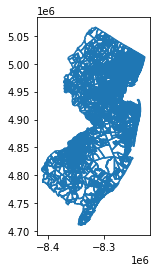

In [52]:
shapefiles_nj.boundary.plot()

In [53]:
print(shapefiles_nj.shape)
vest_shp.shape

(6348, 14)


(6339, 21)

<AxesSubplot:>

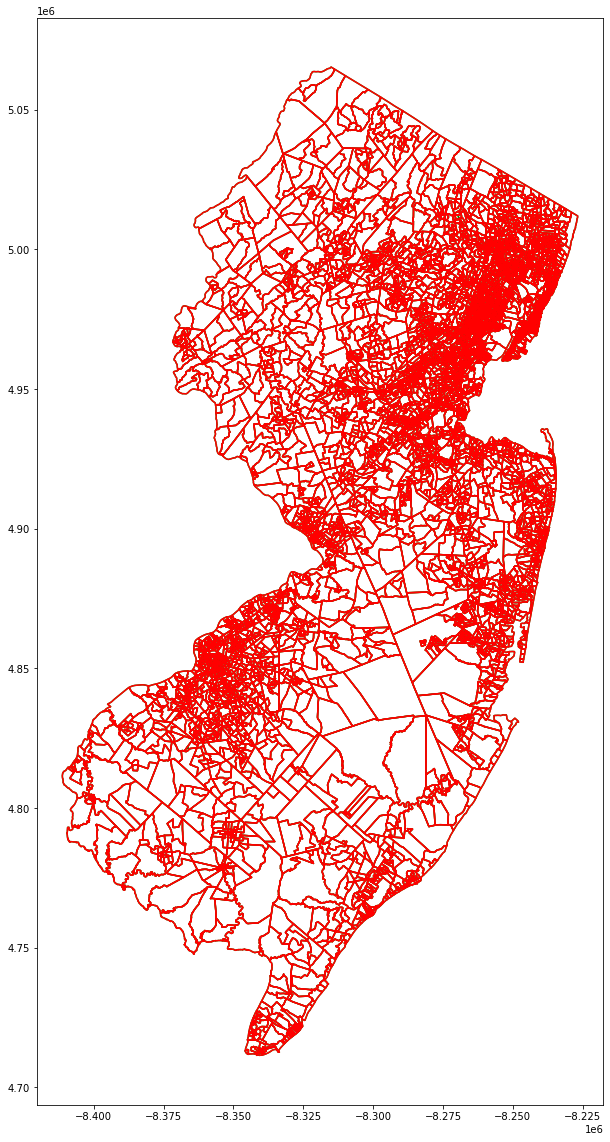

In [54]:
ax = shapefiles_nj.boundary.plot(figsize=(20,20),color="green")
vest_shp.boundary.plot(figsize=(20,20),ax=ax,color="red")

## Complete Merges

VEST- Gloucester: Merge Glassboro 1/13
Hudson: Merge Jersey City Ward E 9/24, 6/25; Realign Union City Ward 9 precincts
Passaic: Merge Pompton Lakes 3/6
Union: Merge Elizabeth City W1 6/9, W2 2/11, W3 10/13, W4 7/10; Adjust Elizabeth City W2 4/7, 6/7, W3 3/6, W6 1/5

<AxesSubplot:>

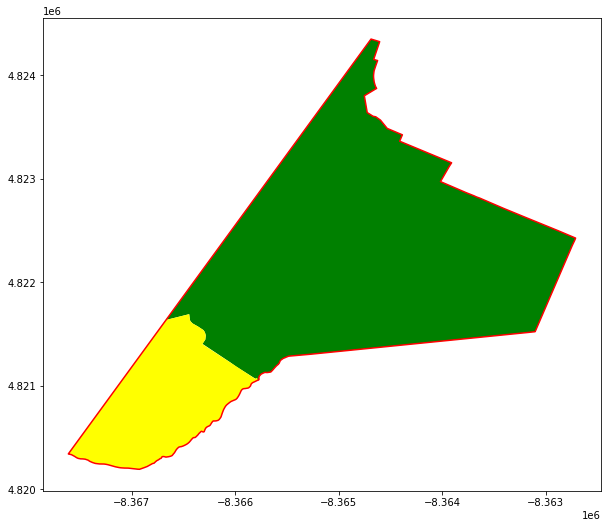

In [55]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '015-0806-00-01'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '015-0806-00-01'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '015-0806-00-13'].plot(figsize=(10,10),ax=ax,color="yellow")

In [56]:
#Merge precincts in Gloucester
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="015-0806-00-01"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="015-0806-00-13"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="015-0806-00-01","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="015-0806-00-13"]

<ipython-input-56-0809ff9fbe02>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

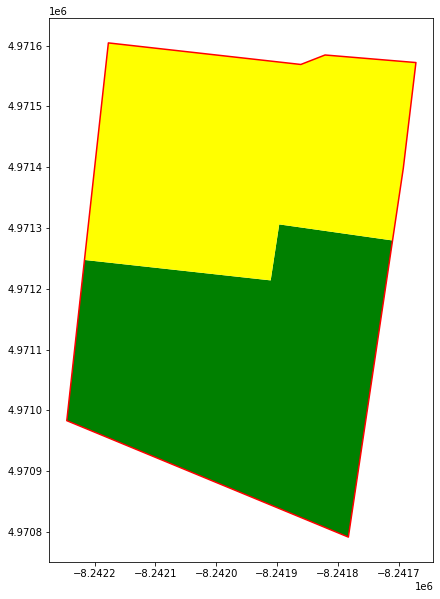

In [57]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '017-0906-E-09'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-09'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-24'].plot(figsize=(10,10),ax=ax,color="yellow")

In [58]:
#Merge precincts in Hudson
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-09"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-24"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-09","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="017-0906-E-24"]

<ipython-input-58-d40cc0d15d90>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

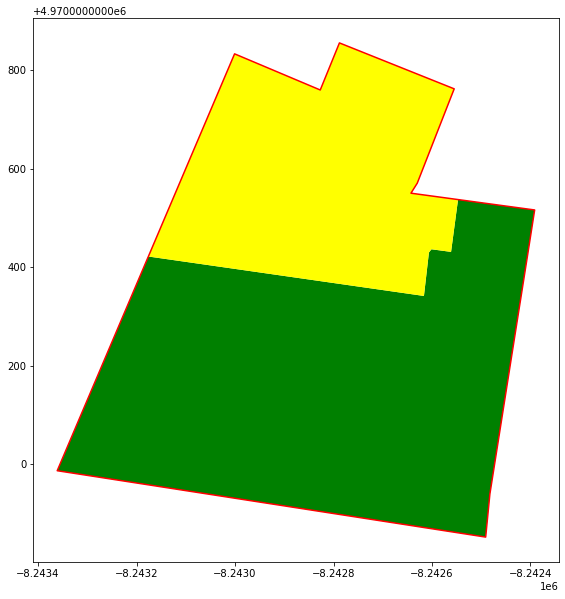

In [59]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '017-0906-E-06'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-06'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-25'].plot(figsize=(10,10),ax=ax,color="yellow")

In [60]:
#Merge precincts in Hudson
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-06"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-25"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-06","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="017-0906-E-25"]

<ipython-input-60-7886eb6963d0>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

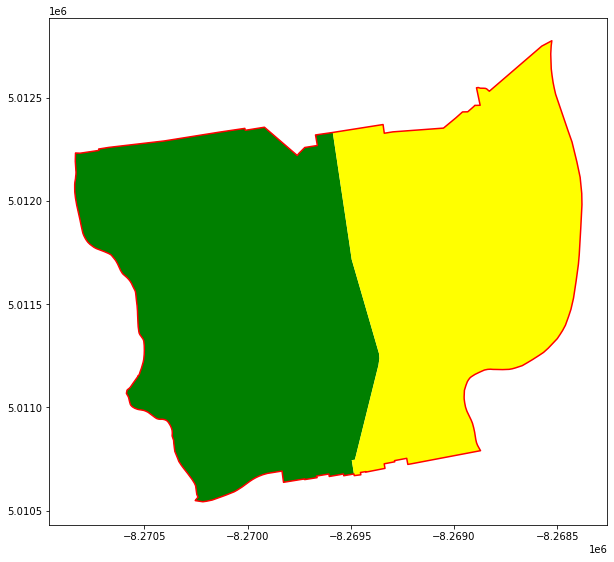

In [61]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '031-1609-00-03'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '031-1609-00-03'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '031-1609-00-06'].plot(figsize=(10,10),ax=ax,color="yellow")

In [62]:
#Merge precincts in Passaic
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="031-1609-00-03"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="031-1609-00-06"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="031-1609-00-03","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="031-1609-00-06"]

<ipython-input-62-2f50c89ceaa5>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

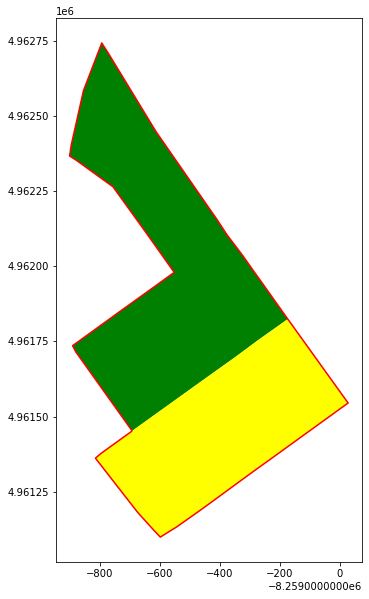

In [63]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '039-2004-01-06'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-01-06'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-01-09'].plot(figsize=(10,10),ax=ax,color="yellow")

In [64]:
#Merge precincts in Union
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-01-06"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-01-09"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-01-06","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="039-2004-01-09"]

<ipython-input-64-d637ce16e255>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

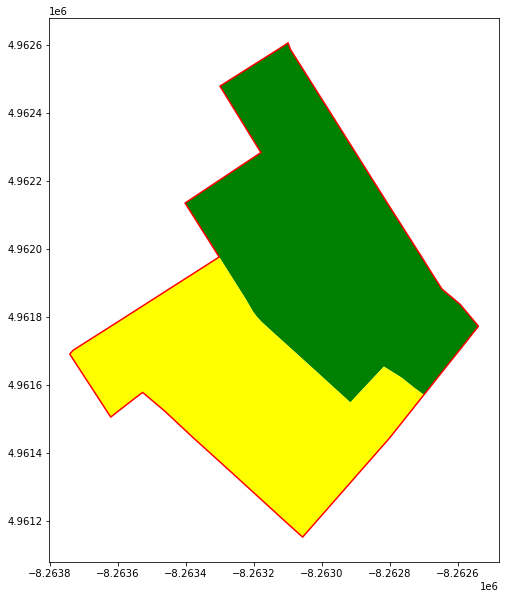

In [65]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '039-2004-02-02'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-02-02'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-02-11'].plot(figsize=(10,10),ax=ax,color="yellow")

In [66]:
#Merge precincts in Union
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-02-02"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-02-11"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-02-02","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="039-2004-02-11"]

<ipython-input-66-923d81a0413b>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

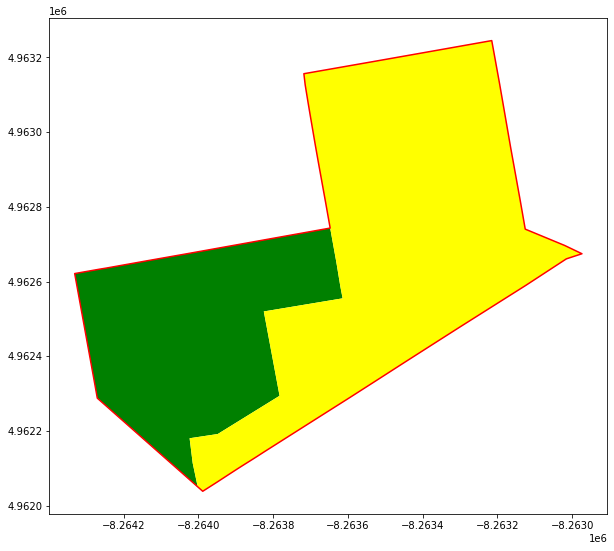

In [67]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '039-2004-03-10'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-03-10'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-03-13'].plot(figsize=(10,10),ax=ax,color="yellow")

In [68]:
#Merge precincts in Union
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-03-10"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-03-13"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-03-10","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="039-2004-03-13"]

<ipython-input-68-7cc23ed420ae>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

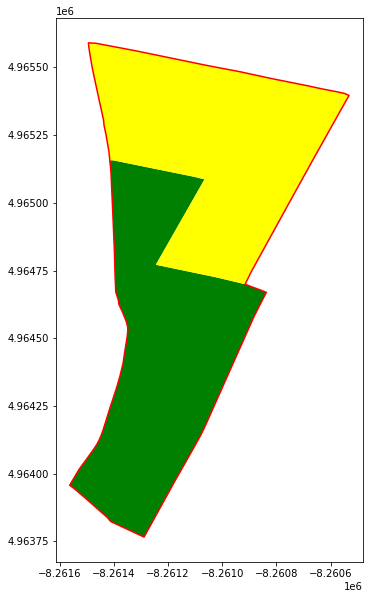

In [69]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '039-2004-04-07'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-04-07'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '039-2004-04-10'].plot(figsize=(10,10),ax=ax,color="yellow")

In [70]:
#Merge precincts in Union
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-04-07"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-04-10"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="039-2004-04-07","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="039-2004-04-10"]

<ipython-input-70-209b6292b80c>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


In [71]:
final_merge = pd.merge(shapefiles_nj,vest_shp,how="outer",on="ELECD_KEY",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          6338
left_only        2
right_only       1
Name: final_merge, dtype: int64

In [72]:
final_merge[final_merge["final_merge"] != 'both'][['COUNTY_x','MUN_NAME_x','COUNTY_y','MUN_NAME_y','ELECD_KEY']]

,COUNTY_x,MUN_NAME_x,COUNTY_y,MUN_NAME_y,ELECD_KEY
2202,Hudson,Union City,NaN,NaN,017-0910-09-05
5970,Hudson,Union City,NaN,NaN,017-0910-09-06
6340,NaN,NaN,MONMOUTH,Middletown Township,000-0000-00-00


In [73]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     6315
False      23
dtype: int64


In [74]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .5):
        count += 1
        name = source_geoms.iat[i,3]
        county = source_geoms.iat[i,1]
        
        print(str(count)+") For " + str(county) + '-' + str(name) + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [75]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and 0.1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between 0.1 and 0.5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between 0.5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(6338, 1)
6322 precincts w/ a difference of 0 km^2
16 precincts w/ a difference between 0 and 0.1 km^2
0 precincts w/ a difference between 0.1 and 0.5 km^2
0 precincts w/ a difference between 0.5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2
